In [ ]:
from google.colab import drive
drive.mount("/content/drive")

ROOT = "/content/drive/Shareddrives/CSC 591/Color Threshold Segmented for Labelling/"
IMAGES = "/content/drive/Shareddrives/CSC 591/Color Threshold Segmented for Labelling/ColorImages/"
MASKS = "/content/drive/Shareddrives/CSC 591/Color Threshold Segmented for Labelling/masks/"

import gc
import os
import cv2
import csv
import copy 
import glob
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data as data
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch.utils import data
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, roc_auc_score
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

%matplotlib inline
gc.collect()

Mounted at /content/drive


13

In [ ]:
class DataLoaderSegmentation(data.Dataset):
  def __init__(self, image_folder, mask_folder):
    super(DataLoaderSegmentation, self).__init__()
    self.image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))
    self.mask_files = sorted(glob.glob(os.path.join(mask_folder, '*.png')))

  def __getitem__(self, index):
    image_path = self.image_files[index]
    mask_path = self.mask_files[index]
    # Tensor dimensions - [channels x height x width]
    data = np.transpose(np.array(Image.open(image_path)))
    label = np.transpose(np.array(Image.open(mask_path)))
    data = np.swapaxes(data, 1, 2)
    label = np.swapaxes(label, 0, 1)
    sample = {'image': torch.from_numpy(data).float(), 
              'mask': torch.from_numpy(label).unsqueeze(0).float() / 255.0}
    return sample

  def __len__(self):
    return len(self.image_files)

def init_DeepLabv3(outputchannels = 1):
  model = models.segmentation.deeplabv3_resnet101(pretrained = True, progress = True)
  model.classifier = DeepLabHead(2048, outputchannels)
  model.train() # Set the model in training mode
  return model

def training_loop(net, dataloaders, loss_function, metrics, device, optimizer, log_path):
  best_model_weights = copy.deepcopy(net.state_dict())
  best_loss = 1e10
  net.to(device) # Load model to device
  num_epochs = 8

  batch_summary = None # Initialize outside of loop
  field_names = ['Epoch', 'Train Loss', 'Test Loss'] + \
   [f'Train {m}' for m in metrics.keys()] + \
   [f'Test {m}' for m in metrics.keys()]

  with open(os.path.join(log_path, 'log_deeplabv3.csv'), 'w', newline = '') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = field_names)
    writer.writeheader()

  for epoch in range(num_epochs):
    # Track progress of training
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    batch_summary = {a: [0] for a in field_names}

    for phase in ['Train', 'Test']:
      if phase == 'Train':
        net.train() # Training mode
      else:
        net.eval() # Evaluation/test mode

      # dataloaders[phase] is the DataLoader object you need to iterate over
      for sample in tqdm(iter(dataloaders[phase])):
        inputs = sample['image'].to(device)
        masks = sample['mask'].to(device).float() # Ground truth
        optimizer.zero_grad() # Clear previously stored gradients

        with torch.set_grad_enabled(phase == 'Train'):
          outputs = net(inputs)
          loss = loss_function(outputs['out'], masks)
          y_pred = outputs['out'].data.cpu().numpy().ravel()
          y_true = masks.data.cpu().numpy().ravel()
          
          for name, metric in metrics.items():
            if name == 'f1_score':
              batch_summary[f'{phase} {name}'].append(metric(y_true > 0 , y_pred > 0.1))
            elif name == 'auroc':
              batch_summary[f'{phase} {name}'].append(metric(y_true, y_pred))
          
          # Backwards pass - optimize only if in training phase
          if phase == 'Train':
            loss.backward()
            optimizer.step()
    
      batch_summary['Epoch'] = epoch
      epoch_loss = loss
      batch_summary[f'{phase} Loss'] = epoch_loss.item()
      print('{} Loss: {:.4f}'.format(phase, loss))
      
    for field in field_names[3:]:
      batch_summary[field] = np.mean(batch_summary[field])
    
    print(batch_summary)

    with open(os.path.join(log_path, 'log_deeplabv3.csv'), 'a', newline = '') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames = field_names)
      writer.writerow(batch_summary)
      if phase == 'Test':
        best_loss = loss
        best_model_weights = copy.deepcopy(net.state_dict())
  
  net.load_state_dict(best_model_weights)
  return net

In [ ]:
# [batch_size x channels x height x width]
datasets = {
    x: DataLoaderSegmentation(IMAGES, MASKS)
    for x in ['Train', 'Test']
}

d = DataLoaderSegmentation(IMAGES, MASKS)
# Validating shapes and sizes of the data
print("Number of image files: " + str(len(d.image_files)))
print("Number of mask files: " + str(len(d.mask_files)))
print(datasets['Train'].__getitem__(0)['image'].shape)
print(datasets['Train'].__getitem__(0)['mask'].shape)
print(type(datasets['Train'].__getitem__(0)['image']))
check_sample = datasets['Train'].__getitem__(0)['mask']
print(check_sample[(check_sample > 0)])

# Create the dataloader - consists of training and test data
dataloaders = {
    x: DataLoader(datasets[x],
                  batch_size = 2,
                  shuffle = True,
                  drop_last = True)
    for x in ['Train', 'Test']
}

# Initialize the DeepLabv3 model
model = init_DeepLabv3()
model.train()

# Binary cross entropy loss function, Adam optimizer, and evaluation metrics
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

# Load network on to CUDA if available
#torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Number of image files: 1597
Number of mask files: 1597
torch.Size([3, 480, 640])
torch.Size([1, 480, 640])
<class 'torch.Tensor'>
tensor([1., 1., 1.,  ..., 1., 1., 1.])


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
net = training_loop(model, dataloaders, loss_function, metrics, device, optimizer, ROOT)

Epoch 1/8


100%|██████████| 798/798 [35:07<00:00,  2.64s/it]


Train Loss: 0.0430


100%|██████████| 798/798 [09:29<00:00,  1.40it/s]


Test Loss: 0.0226
{'Epoch': 0, 'Train Loss': 0.043010637164115906, 'Test Loss': 0.02256893739104271, 'Train f1_score': 0.9547565288369714, 'Train auroc': 0.9939394741211851, 'Test f1_score': 0.9740412652899866, 'Test auroc': 0.9977920877737737}
Epoch 2/8


100%|██████████| 798/798 [20:23<00:00,  1.53s/it]


Train Loss: 0.0157


100%|██████████| 798/798 [09:33<00:00,  1.39it/s]


Test Loss: 0.0127
{'Epoch': 1, 'Train Loss': 0.015661627054214478, 'Test Loss': 0.012739761732518673, 'Train f1_score': 0.9780022626967235, 'Train auroc': 0.9978786624441883, 'Test f1_score': 0.9823661590253475, 'Test auroc': 0.9983645521147076}
Epoch 3/8


100%|██████████| 798/798 [20:24<00:00,  1.53s/it]


Train Loss: 0.0231


100%|██████████| 798/798 [09:32<00:00,  1.39it/s]


Test Loss: 0.0328
{'Epoch': 2, 'Train Loss': 0.023135777562856674, 'Test Loss': 0.032767120748758316, 'Train f1_score': 0.9849672537036167, 'Train auroc': 0.9984039737689858, 'Test f1_score': 0.9826687810588672, 'Test auroc': 0.998469545124504}
Epoch 4/8


100%|██████████| 798/798 [20:22<00:00,  1.53s/it]


Train Loss: 0.0144


100%|██████████| 798/798 [09:32<00:00,  1.39it/s]


Test Loss: 0.0062
{'Epoch': 3, 'Train Loss': 0.01440871600061655, 'Test Loss': 0.006198839284479618, 'Train f1_score': 0.9857862341536405, 'Train auroc': 0.998497842365763, 'Test f1_score': 0.9855773313935039, 'Test auroc': 0.9984949624955333}
Epoch 5/8


100%|██████████| 798/798 [20:22<00:00,  1.53s/it]


Train Loss: 0.0223


100%|██████████| 798/798 [09:30<00:00,  1.40it/s]


Test Loss: 0.0121
{'Epoch': 4, 'Train Loss': 0.02230551280081272, 'Test Loss': 0.012088912539184093, 'Train f1_score': 0.9761230686738838, 'Train auroc': 0.9975913877692438, 'Test f1_score': 0.9716589052462681, 'Test auroc': 0.9976578493400627}
Epoch 6/8


100%|██████████| 798/798 [20:21<00:00,  1.53s/it]


Train Loss: 0.0240


100%|██████████| 798/798 [09:32<00:00,  1.39it/s]


Test Loss: 0.0046
{'Epoch': 5, 'Train Loss': 0.023986414074897766, 'Test Loss': 0.0046168784610927105, 'Train f1_score': 0.9834386863492321, 'Train auroc': 0.9983517301433351, 'Test f1_score': 0.9871871896456695, 'Test auroc': 0.9985449934559727}
Epoch 7/8


100%|██████████| 798/798 [20:22<00:00,  1.53s/it]


Train Loss: 0.0069


100%|██████████| 798/798 [09:33<00:00,  1.39it/s]


Test Loss: 0.0148
{'Epoch': 6, 'Train Loss': 0.0069451904855668545, 'Test Loss': 0.014788532629609108, 'Train f1_score': 0.9872483364319168, 'Train auroc': 0.99855793974994, 'Test f1_score': 0.9870474340105295, 'Test auroc': 0.9985756035113974}
Epoch 8/8


100%|██████████| 798/798 [20:19<00:00,  1.53s/it]


Train Loss: 0.0091


100%|██████████| 798/798 [09:31<00:00,  1.40it/s]

Test Loss: 0.4031
{'Epoch': 7, 'Train Loss': 0.009061599150300026, 'Test Loss': 0.403147429227829, 'Train f1_score': 0.9832877731698872, 'Train auroc': 0.9984080320513823, 'Test f1_score': 0.967882959483763, 'Test auroc': 0.9977552480220795}


In [ ]:
torch.save(net, ROOT + 'baseline_deeplabv3_2.pt') # Save the model weights

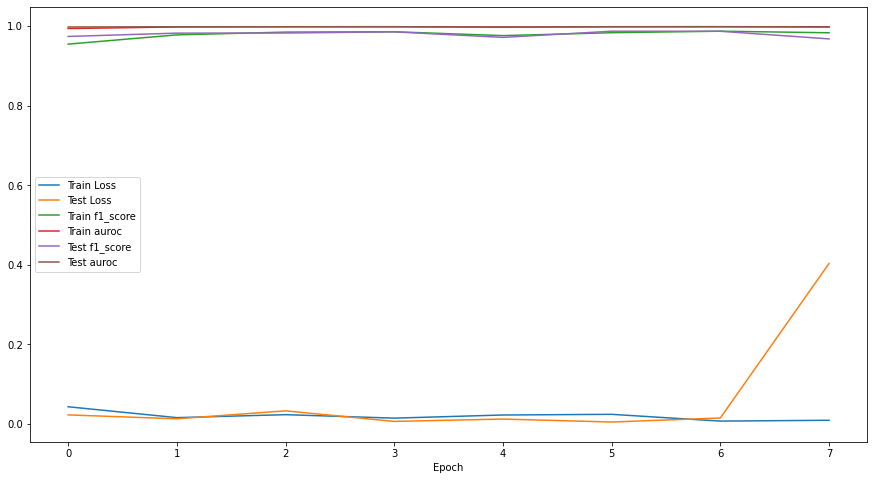

In [ ]:
df = pd.read_csv(ROOT + 'log_deeplabv3.csv')
df.plot(x = 'Epoch', figsize = (15, 8))

In [ ]:
baseline = torch.load(ROOT + 'baseline_deeplabv3_2.pt')
baseline.eval() # Evaluation mode

# Sample predictions
image = np.reshape(np.swapaxes(np.transpose(Image.open(IMAGES + 'buttjoint_000115.png')), 1, 2), (1, 3, 480, 640))
mask = cv2.imread(MASKS + 'buttjoint_000115_output.png')

with torch.no_grad():
  a = baseline(torch.from_numpy(image).type(torch.cuda.FloatTensor))

image2 = np.reshape(np.swapaxes(np.transpose(Image.open(IMAGES + 'tjoint_123105000329.png')), 1, 2), (1, 3, 480, 640))
mask2 = cv2.imread(MASKS + 'tjoint_123105000329_output.png')

with torch.no_grad():
  b = baseline(torch.from_numpy(image2).type(torch.cuda.FloatTensor))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  if __name__ == '__main__':


(array([ 3540., 88755., 83279., 43704.,  7443.,  6318., 15696., 36129.,
        20664.,  1672.]),
 array([-12.884095  ,  -9.786132  ,  -6.688168  ,  -3.5902042 ,
         -0.49224073,   2.605723  ,   5.7036867 ,   8.80165   ,
         11.899613  ,  14.997578  ,  18.095541  ], dtype=float32),
 <a list of 10 Patch objects>)

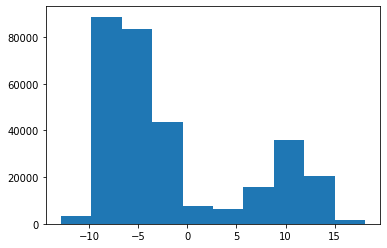

In [ ]:
plt.hist(a['out'].data.cpu().numpy().flatten()) 
# From the histogram, 1 seems to be a suitable threshold

(array([ 43960., 169987.,  18762.,   2378.,   2011.,   2206.,   6045.,
         33478.,  23844.,   4529.]),
 array([-12.647412 ,  -9.832378 ,  -7.017344 ,  -4.20231  ,  -1.3872759,
          1.4277582,   4.242792 ,   7.0578265,   9.872861 ,  12.687895 ,
         15.502929 ], dtype=float32),
 <a list of 10 Patch objects>)

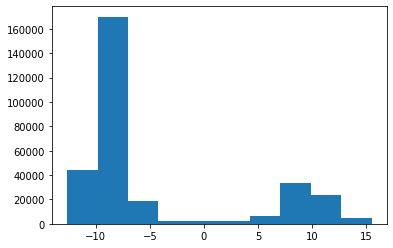

In [ ]:
plt.hist(b['out'].data.cpu().numpy().flatten()) 
# From the histogram, 1 seems to be a suitable threshold

(-0.5, 639.5, 479.5, -0.5)

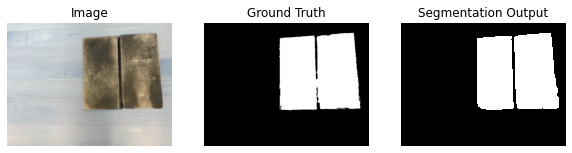

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(131)
plt.imshow(image[0,...].transpose(1, 2, 0))
plt.title('Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(mask)
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(133)
plt.imshow(a['out'].cpu().detach().numpy()[0][0] < 1,
           cmap = "Greys", interpolation = "nearest")
plt.title('Segmentation Output')
plt.axis('off')

(-0.5, 639.5, 479.5, -0.5)

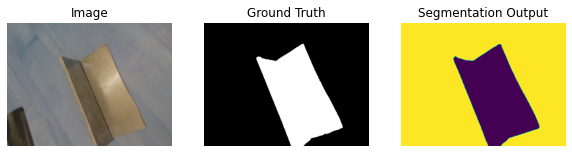

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(131)
plt.imshow(image2[0,...].transpose(1, 2, 0))
plt.title('Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(mask2)
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(133)
plt.imshow(b['out'].cpu().detach().numpy()[0][0] < 1)
plt.title('Segmentation Output')
plt.axis('off')

In [ ]:
COLOR_IMAGES = '/content/drive/Shareddrives/CSC 591/ROS_BAGS/color/'
image = np.reshape(np.swapaxes(np.transpose(Image.open(COLOR_IMAGES + 'tjoint_123105000261.png')), 1, 2), (1, 3, 480, 640))
image2 = np.reshape(np.swapaxes(np.transpose(Image.open(COLOR_IMAGES + 'buttjoint_001545.png')), 1, 2), (1, 3, 480, 640))
image_aug = np.reshape(np.swapaxes(np.transpose(Image.open(COLOR_IMAGES + 'augmented_tjoint/_822_tjoint.png')), 1, 2), (1, 3, 480, 640))
img_tjoint_far = np.reshape(np.swapaxes(np.transpose(Image.open(COLOR_IMAGES + 'tjoint_003802.png')), 1, 2), (1, 3, 480, 640))
tjoint = np.reshape(np.swapaxes(np.transpose(Image.open(COLOR_IMAGES + 'tjoint_122852000013.png')), 1, 2), (1, 3, 480, 640))

with torch.no_grad():
  e = baseline(torch.from_numpy(tjoint).type(torch.cuda.FloatTensor))

with torch.no_grad():
  a = baseline(torch.from_numpy(image).type(torch.cuda.FloatTensor))

with torch.no_grad():
  b = baseline(torch.from_numpy(image2).type(torch.cuda.FloatTensor))

with torch.no_grad():
  c = baseline(torch.from_numpy(image_aug).type(torch.cuda.FloatTensor))

with torch.no_grad():
  d = baseline(torch.from_numpy(img_tjoint_far).type(torch.cuda.FloatTensor))

(array([ 89603., 171651.,   8109.,   1305.,   1156.,   1294.,   5774.,
         17473.,   9777.,   1058.]),
 array([-12.935837 , -10.170335 ,  -7.404834 ,  -4.639332 ,  -1.8738304,
          0.8916712,   3.6571727,   6.422674 ,   9.188176 ,  11.953677 ,
         14.719179 ], dtype=float32),
 <a list of 10 Patch objects>)

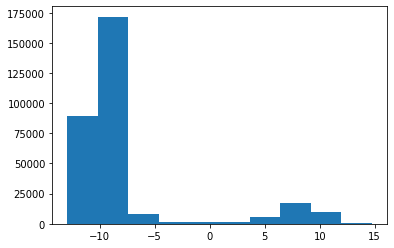

In [ ]:
plt.hist(a['out'].data.cpu().numpy().flatten()) 

(array([7.48200e+03, 1.91629e+05, 7.83650e+04, 1.28350e+04, 4.85900e+03,
        2.62900e+03, 4.33100e+03, 2.94000e+03, 1.94000e+03, 1.90000e+02]),
 array([-15.326686 , -12.521709 ,  -9.716734 ,  -6.9117575,  -4.1067815,
         -1.3018055,   1.5031706,   4.3081465,   7.113123 ,   9.918098 ,
         12.723075 ], dtype=float32),
 <a list of 10 Patch objects>)

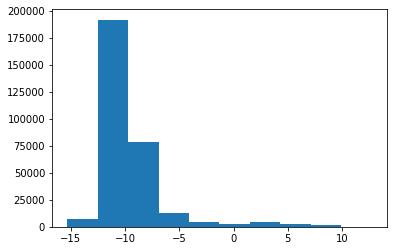

In [ ]:
plt.hist(d['out'].data.cpu().numpy().flatten()) 

(array([  8327., 108138.,  66979.,   6131.,  10455.,  10742.,  21604.,
         33162.,  36659.,   5003.]),
 array([-12.548732 ,  -9.752469 ,  -6.9562054,  -4.1599426,  -1.3636793,
          1.4325838,   4.228847 ,   7.0251102,   9.821373 ,  12.617637 ,
         15.413899 ], dtype=float32),
 <a list of 10 Patch objects>)

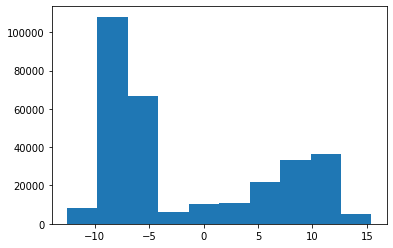

In [ ]:
plt.hist(b['out'].data.cpu().numpy().flatten()) 

(array([10343., 20458., 19324., 25518., 39418., 40503., 43944., 73351.,
        33599.,   742.]),
 array([-1.0095766e+01, -9.0869122e+00, -8.0780582e+00, -7.0692039e+00,
        -6.0603495e+00, -5.0514956e+00, -4.0426412e+00, -3.0337870e+00,
        -2.0249329e+00, -1.0160787e+00, -7.2246240e-03], dtype=float32),
 <a list of 10 Patch objects>)

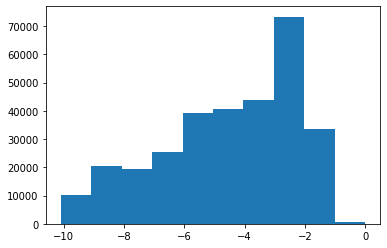

In [ ]:
plt.hist(c['out'].data.cpu().numpy().flatten()) 

(-0.5, 639.5, 479.5, -0.5)

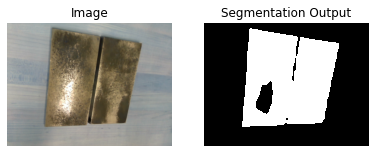

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(131)
plt.imshow(image2[0,...].transpose(1, 2, 0))
plt.title('Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(b['out'].cpu().detach().numpy()[0][0] < 1, cmap = "Greys", interpolation = "nearest")
plt.title('Segmentation Output')
plt.axis('off')

(-0.5, 639.5, 479.5, -0.5)

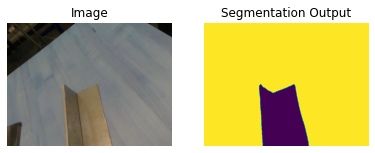

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(131)
plt.imshow(image[0,...].transpose(1, 2, 0))
plt.title('Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(a['out'].cpu().detach().numpy()[0][0] < 1)
plt.title('Segmentation Output')
plt.axis('off')

(-0.5, 639.5, 479.5, -0.5)

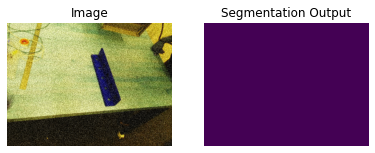

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(131)
plt.imshow(image_aug[0,...].transpose(1, 2, 0))
plt.title('Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(c['out'].cpu().detach().numpy()[0][0] < 1)
plt.title('Segmentation Output')
plt.axis('off')

(-0.5, 639.5, 479.5, -0.5)

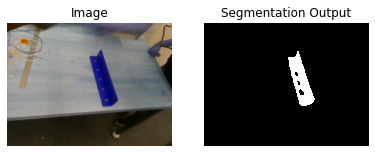

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(131)
plt.imshow(img_tjoint_far[0,...].transpose(1, 2, 0))
plt.title('Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(d['out'].cpu().detach().numpy()[0][0] < 1, cmap = "Greys", interpolation = "nearest")
plt.title('Segmentation Output')
plt.axis('off')

(-0.5, 639.5, 479.5, -0.5)

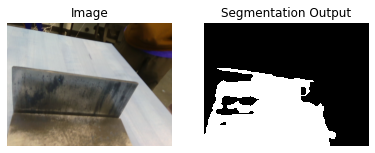

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(131)
plt.imshow(tjoint[0,...].transpose(1, 2, 0))
plt.title('Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(e['out'].cpu().detach().numpy()[0][0] < 1, cmap = "Greys", interpolation = "nearest")
plt.title('Segmentation Output')
plt.axis('off')

(array([24770., 64617., 59793., 21304., 15833., 27942., 41645., 28630.,
        18217.,  4449.]),
 array([-12.185491  ,  -9.863271  ,  -7.5410504 ,  -5.21883   ,
         -2.89661   ,  -0.57438993,   1.7478302 ,   4.0700502 ,
          6.3922706 ,   8.714491  ,  11.036711  ], dtype=float32),
 <a list of 10 Patch objects>)

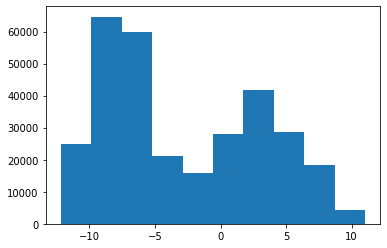

In [ ]:
plt.hist(e['out'].data.cpu().numpy().flatten()) 